# Clustering and Topic Models 

## Question 1: Clustering emails using Gaussian Mixture Models

### Part A: Construct a list of processed documents 

In [175]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [176]:
import glob
email_docs=[]
for file in glob.glob('./enron/*.txt'):
    email_docs.append(makeWordList(file))

### Part B: Construct a document matrix 

In [180]:
 from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=50,stop_words="english",max_df=0.8)
X = vectorizer.fit_transform(email_docs)
vocab=[]
for k in  vectorizer.vocabulary_.keys():
    vocab.append(k)

### Part C: Perform Clustering

In [181]:
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt

X = X.toarray()
gmm = GMM(n_components=3,random_state=0).fit(X)
probs = gmm.predict_proba(X)
total_docs=(len(email_docs))
l = gmm.weights_
print("Number of documents")
print("--------------------")
#the third cluster is made up of 3021.9999999 documents
print("Cluster 1: %5d\nCluster 2: %5d\nCluster 3: %5d"%(l[0]*total_docs, l[1]*total_docs, l[2]*total_docs))

Number of documents
--------------------
Cluster 1:   363
Cluster 2:  1786
Cluster 3:  3021


### Part D: Characterize the clusters 

In [6]:
def plot_spam_words_by_cluster(predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

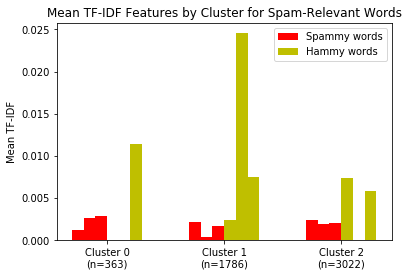

In [86]:
# Spam: sensual, www, click
# Ham: review, attached ,accounts
#print(sorted(vocab))
spam_indices = [vocab.index("sexual"), vocab.index('www'), vocab.index("click")]
ham_indices = [vocab.index("review"), vocab.index("attached"), vocab.index("accounts")]
plot_spam_words_by_cluster(gmm.predict(X), 3, spam_indices, ham_indices)


### Part E: Interpret results

Based on the frequency of the spammy and hammy words there were no clusters that corresponded definitevly with sam emails. Cluster 1 does seem to correspond to typical business emails. Cluster 2 is the closest cluster in the group that may correspond with spam emails but the words need more refining, it could also be Enron's questionable business practices. 

Rerunning the analysis with different numbers for the clusters, specifically used n_clusters=2 and n_clusters=5, changed the dispersal 
of the results. With n_clusters = 2 there was one cluster that was obviously hammy words but neither cluster was 
definitively "spammy". With n_clusters = 5 there was more definition by word in the clusters. One of the clusters was almost entirely made up of documents witht the word "accounts". It reflected the other n_cluster sizes in that none of the clusters were made up of a significant count of spammy words versus hammy words. At n_clusters=5 there was an empty cluster which means we are trying to force too many clusters on the dataset.

## Question 2: Latent "Purposes" in Mobile Apps 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data 

In [2]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [3]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [4]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" 



In [5]:
import builtins
list = builtins.list
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.as_matrix()
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

C:\Users\Molly\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


### Part C: Downweight "stop-words"


In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
tf = transformer.fit_transform(X)



### Part D: Discover 10 "topics"



In [11]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
l_fit = lda.fit(tf)

Wall time: 5min 34s


In [10]:
l_fit.components_.shape

(10, 173)

In [12]:
l_fit.components_.sum(axis=1)
topic_word_distributions = np.array([row / row.sum() for row in l_fit.components_])
topic_word_distributions.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic

In [33]:
num_top_words = 10

print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print("%-80s  %f"%(permission_columns[word_idx],topic_word_distributions[topic_idx, word_idx]))
    print()

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
Your location : coarse (network-based) location (D)                               0.342968
Your location : fine (GPS) location (D)                                           0.323157
Network communication : full Internet access (D)                                  0.170572
Network communication : view network state (S)                                    0.090563
Your location : access extra location provider commands (S)                       0.038943
System tools : send sticky broadcast (S)                                          0.023102
Default : control location update notifications (S)                               0.007897
Default : permission to install a location provider (S)                           0.001821
Default : monitor and control all application launching (S)                       0.000284
Your location : mock location sources for testing (D)                             0.0000


Seemingly meaningful topic groupings: 

Topic 0 seems to be about location services for apps 

Topic 1: device state controls

Topic 2 seems to be about messaging

Topic 3 might be messaging/calling/location? Something related to long distance phone use/using phone in foreign countries?

Topic 4: phone memory settings

Topic 6: taking videos and photos on the phone

Topic 8: some type of device OS controls

Topic 9: something to do with the phone state and being awake

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic 

In [93]:
def get_rank(topic_idx, topic_to_document, documents, no_top_docs):
        print("Top Applications Topic %d:" % (topic_idx))
        top_doc_indices = np.argsort(-topic_to_document[:,topic_idx] )
        the_count=0
        for doc_index in top_doc_indices:
                if(the_count==no_top_docs):
                    return
                if(documents[doc_index] in top_apps):
                    the_count+=1
                    print(documents[doc_index])   

In [94]:
df3=df.loc[(df['Number of ratings'] >= 100000)]
top_apps=list(df3['App'])

no_top_docs=3
lda_topic_to_document = lda.transform(tf)
lda_topic_to_word = l_fit.components_
for topic_idx,topic in enumerate(lda_topic_to_word):
    get_rank(topic_idx, lda_topic_to_document, app_names, no_top_docs)
    print()


Top Applications Topic 0:
Street View on Google Maps
Toss It
GasBuddy

Top Applications Topic 1:
Mouse Trap
Bubble Blast 2
Drag Racing

Top Applications Topic 2:
Angry Birds Seasons
Yoo Ninja! Free
Adobe Reader

Top Applications Topic 3:
GO SMS Pro
TweetCaster for Twitter
Zynga Poker

Top Applications Topic 4:
Racing Moto
Angry Birds
Angry Birds Rio

Top Applications Topic 5:
Real BlackJack
Robo Defense FREE
SpeechSynthesis Data Installer

Top Applications Topic 6:
Seesmic (Facebook, Twitter)
Tiny Flashlight + LED
ColorNote Notepad Notes

Top Applications Topic 7:
Blast Monkeys
World Newspapers
Paradise Island

Top Applications Topic 8:
Wallpapers HD
Strip Poker
Backgrounds HD Wallpapers

Top Applications Topic 9:
Twitter
YouTube
Meet New People



### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE

In [182]:
np.random.seed(0)
random_sample = np.random.permutation(lda_topic_to_document.shape[0])[:2000]  # 10000 random indices
lda_mini = lda_topic_to_document[random_sample,:]


In [183]:
top_doc_index=[]
top_doc_index_map=[]
for i in range(180295):
    top_doc_index=np.argsort(-lda_topic_to_document[i,:])
    top_doc_index_map.append(top_doc_index[0])
np_ar=np.array(top_doc_index_map)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.006s...
[t-SNE] Computed neighbors for 2000 samples in 0.146s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.383518
[t-SNE] KL divergence after 5000 iterations: -1.162120
Wall time: 1min 23s


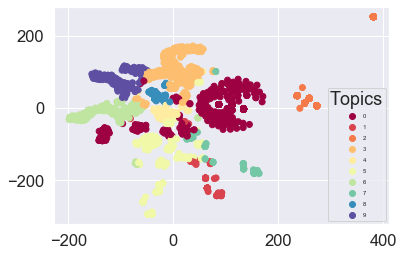

In [173]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30,verbose=1,init='pca', learning_rate=100,n_iter=5000, random_state=0,angle=.99)
android_tsne = tsne.fit_transform(lda_mini)
labels=[topic_idx for topic_idx,topic in enumerate(lda_topic_to_word)]

scatter=plt.scatter(android_tsne[:, 0], android_tsne[:, 1],c=[i for i in np_ar[random_sample]],cmap='Spectral')
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Topics",prop={'size': 6},loc='lower right')